In [1]:
import os
import colorcet as cc
from colour import Color

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

import pymeshlab as ml

import pyvista as pv
from pyvista import examples


from collections import defaultdict

from colorspacious import cspace_converter
pv.global_theme.transparent_background = True

## Get hausdorff distance for models1, models2

### convert

In [2]:
#---------convert files to .stl-----------------
# tmp = os.listdir()
# import meshio
# fnames = ['pialnn/pp.obj','pialnn/tp.obj','vox2cortex/pp.ply','vox2cortex/pw.ply','vox2cortex/tp.ply','vox2cortex/tw.ply']
# for fname in fnames:
#     mesh = meshio.read(pre+fname)
#     meshio.write(pre+fname[:-4]+'.stl', mesh, file_format="stl")

### prepare data

In [3]:
pre = '../../data/201818/'


models1 = ['cortexode','corticalflow','deepcsr','pialnn','vox2cortex']
models2 = ['cortexode','corticalflow','deepcsr','topofit','vox2cortex']

fs = ['tp.stl', 'pp.stl', 'tw.stl', 'pw.stl']
file_truths1 = [pre+'./'+m+'/'+fs[0] for m in models1]
files1 = [pre+'./'+m+'/'+fs[1] for m in models1]

file_truths2 = [pre+'./'+m+'/'+fs[2] for m in models2]
files2 = [pre+'./'+m+'/'+fs[3] for m in models2]



In [6]:
files1

['../../data/201818/./cortexode/pp.stl',
 '../../data/201818/./corticalflow/pp.stl',
 '../../data/201818/./deepcsr/pp.stl',
 '../../data/201818/./pialnn/pp.stl',
 '../../data/201818/./vox2cortex/pp.stl']

In [7]:
files2

['../../data/201818/./cortexode/pw.stl',
 '../../data/201818/./corticalflow/pw.stl',
 '../../data/201818/./deepcsr/pw.stl',
 '../../data/201818/./topofit/pw.stl',
 '../../data/201818/./vox2cortex/pw.stl']

### helper functions

In [8]:
def calc_distance():
    """
    return mesh with distance as an attribute
    """
    ms = ml.MeshSet()
    ms.load_new_mesh(file_truth)
    ms.load_new_mesh(file)
    ms.compute_scalar_by_distance_from_another_mesh_per_vertex()
    ms.compute_color_from_scalar_per_vertex()
    return ms

def calc_hausdorff_distance(file_truth, file):
    """
    return Hausdorff distance.
    """
    ms = ml.MeshSet()
    ms.load_new_mesh(file_truth)
    ms.load_new_mesh(file)
    d = ms.get_hausdorff_distance()
    return d 

def get_hdd(files,file_truths):
    """
    return Hausdorff Distance for multiple files.
    """
    tmps = []
    for i in range(len(files)):
        file_truth = file_truths[i]
        file = files[i]
        d = calc_hausdorff_distance(file_truth, file)
        tmps.append(d)
    return tmps

def calculate_tmp(tmp, d, attr,way='william'):
    """
    normalize the distance values by percentage of attr ('diag_mesh0')
    """
    if way=='william':
        return [abs(j)/d[attr]*100 for j in tmp] # normalize with diag_mesh distance
    return [abs(j) for j in tmp]


def truncate_tmp(tmp,lower_percentile=5, higher_percentile = 95):  
    """
    remove the 'outliers' in distance
    """
    print('max of distance before truncation is : ',max(tmp))
    minz = np.percentile(tmp, lower_percentile)
    maxz = np.percentile(tmp, higher_percentile)
    # truncate it between minz and maxz
    tmp = [max(max(i, minz),min(i,maxz)) for i in tmp]
    return tmp

def maximize_tmp(mses, tmps, maximize=True, MAX_VALUE = 1.8):
    """
    modify mesh distance values to include the same MAX_VALUE as its max_value
    """
    if maximize:
        for i in range(len(tmps)):
            # modify tmp value to include the same MAX_VALUE as its max_value
            tmps[i] = [min(j, MAX_VALUE) for j in tmps[i]]
            idx = tmps[i].index(max(tmps[i]))
            tmps[i][idx] = MAX_VALUE
            # assign tmp values to mesh
            mses[i]['values'] = tmps[i]
    return mses, tmps
    

def getit(files,file_truths,d,attr,MAX_VALUE=4.5):
    """
    main function
    """
    tmps = []
    mses = []
    for i in range(len(files)):
#         plt.subplot(5,1,i+1)
        file_truth = file_truths[i]
        file = files[i]
        ms2 = ml.MeshSet()
        ms2.load_new_mesh(file_truth)
        ms2.load_new_mesh(file)
        ms2.compute_scalar_by_distance_from_another_mesh_per_vertex()
        ms2.compute_color_from_scalar_per_vertex()
        ms2.apply_color_inverse_per_vertex()

        tmp = list(ms2[1].vertex_scalar_array())
        tmp = calculate_tmp(tmp,d[i], attr)
        tmp = truncate_tmp(tmp)
        tmps.append(tmp)
        
        mesh = pv.read(file)
        mses.append(mesh)
        
    mses,tmps = maximize_tmp(mses,tmps)
    distance = tmps
    return mses, distance

## Get the Coloring Values: tmp1, tmp2

### get (hausdorff) distance

In [9]:
d1 = get_hdd(files1, file_truths1)
d2 = get_hdd(files2, file_truths2)

In [10]:
attr = 'diag_mesh_0'
mses1, tmps1 = getit(files1,file_truths1,d1,attr)
mses2, tmps2 = getit(files2,file_truths2,d2,attr)

max of distance before truncation is :  6.04252876311079
max of distance before truncation is :  2.099364022693511
max of distance before truncation is :  2.169705077863622
max of distance before truncation is :  1.7714791422515495
max of distance before truncation is :  1.2495406642202718
max of distance before truncation is :  6.180894003732273
max of distance before truncation is :  3.4294845901979683
max of distance before truncation is :  4.128479694645356
max of distance before truncation is :  1.3262658326035814
max of distance before truncation is :  1.9227369635716376


## Visualize the distance/diag_mesh_0

In [11]:
def plt_tmp(tmps,suptitle,models):
    plt.figure(figsize=(15,4))
    plt.suptitle(suptitle)
    for i in range(1,6):
        plt.subplot(1,5,i)
        data = tmps[i-1]
        plt.hist(data,bins = 30, weights=np.ones_like(data) / len(data))
        plt.xlim(-0.5,3)
        plt.ylim(0,1)
        plt.title(models[i-1])
        plt.xlabel('distance/diag (%)')
        plt.ylabel('vertex counts Frequency')
        
# plt_tmp(tmps1,'pial',models1)
# plt_tmp(tmps2,'white',models2)

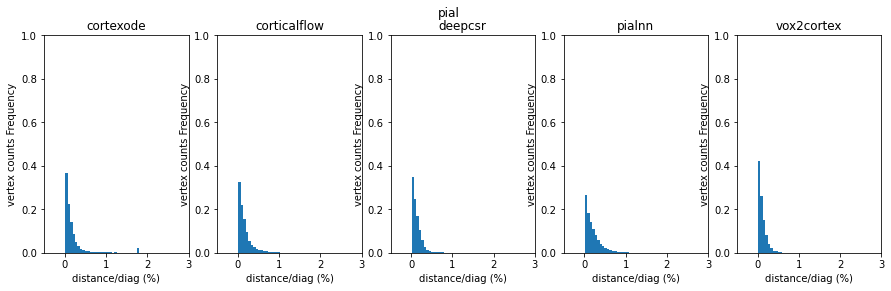

In [12]:
plt_tmp(tmps1,'pial',models1)

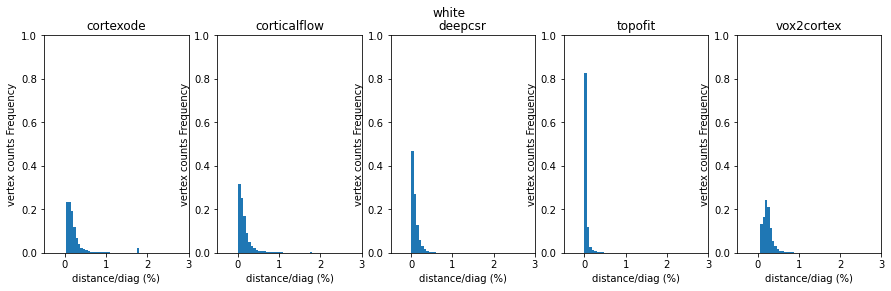

In [13]:
plt_tmp(tmps2,'white',models2)

In [14]:
for i in tmps1:
    print(np.mean(i),min(i))

0.19583986127463665 0.007981503941544234
0.16942744531738582 0.009335837164931087
0.13615797942116406 0.009404336575772394
0.2056617216881602 0.012170800523864525
0.10849997635378301 0.007293770709407603


## Visualize brain and save as PNG

### Play with ColorMap

In [15]:
cmap=mpl.colormaps['inferno']

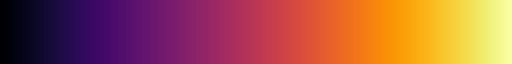

In [16]:
cmap

#### Linear Colors 

In [17]:
cmap = mpl.colormaps['inferno']
n = len(cmap.colors)
cs = [36, 72, 109, 145, 182, 218, 255]
colors = [cmap.colors[i] for i in cs]
colors = [Color(rgb=i) for i in colors]

In [18]:
def getcolormap(colors = colors):
    c = colors
    ccc = defaultdict(list)
    ccc[1] = list(c[0].range_to(c[4],200))
    ccc[7] = list(c[4].range_to(c[-1],56))

    cccs = []
    for k in range(1,8):
        ccc[k] = [list(i.get_rgb())+[1] for i in ccc[k]]
        cccs += ccc[k]

    # Define the colors we want to use
    colors = cccs
    my_colormap = ListedColormap(np.array(colors))
    return my_colormap

def seeit(mesh,):
    my_colormap = getcolormap()
    # Make the colormap from the listed colors
    
    pl = pv.Plotter()
    _ = pl.add_mesh(mesh,cmap=my_colormap)
    pl.set_viewup([0,1,0])
    pl.show()

In [19]:
seeit(mses1[0])

Widget(value="<iframe src='http://localhost:63203/index.html?ui=P_0x7fb5d9ee16d0_0&reconnect=auto' style='widt…

#### Other ways

In [16]:
cmap = mpl.colormaps['inferno']
newcolors = []

for i in range(66):
    newcolors.append(cmap.colors[i])
    newcolors.append(cmap.colors[i])
    newcolors.append(cmap.colors[i])
        
for i in range(80,253):
    if i % 3 == 0:
        newcolors.append(cmap.colors[i])
        


In [17]:
my_colormap = ListedColormap(np.array(newcolors[::-1]))

### Visualize it

In [18]:
cmap_candidates = [mpl.colormaps['inferno'].reversed(), my_colormap,mpl.colormaps['inferno'] ]
def visualize_brain(m = 'pial', models = models1, mses = mses1, scale = 6, cmap_idx = 0):
    cmap = cmap_candidates[cmap_idx]
    for i in range(len(models)):
        viewup1 = [1,0,0]
        viewup2 = [0,0,1]
        mesh = mses[i]
        pl = pv.Plotter()
        actor = pl.add_mesh(mesh,cmap=cmap)

        pl.set_background('white', all_renderers=False)
        pl.remove_scalar_bar()

        pl.view_yz()
        pl.set_viewup(viewup1)
        if i==3 and m == 'pial':
            pl.set_viewup(viewup2)

        pl.remove_legend()
        pl.remove_floors()
        pl.remove_bounding_box()
        pl.remove_bounds_axes()
        pl.update_bounds_axes()
        pl.show()
        pl.screenshot(m + models[i] + '.png', transparent_background=True, return_img=True, scale=scale)

In [19]:
visualize_brain()

2023-05-09 11:59:59.568 (  90.722s) [          52D31F]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7fcf0b80a000): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:51346/index.html?ui=P_0x7fceb0a2fbe0_1&reconnect=auto' style='widt…

2023-05-09 12:00:02.137 (  93.292s) [          52D31F]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7fcefad15a00): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:51346/index.html?ui=P_0x7fcf2248a820_2&reconnect=auto' style='widt…

2023-05-09 12:00:04.831 (  95.986s) [          52D31F]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7fcefbc4bc00): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:51346/index.html?ui=P_0x7fcf1199e070_3&reconnect=auto' style='widt…

2023-05-09 12:00:07.338 (  98.492s) [          52D31F]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7fcefbc9bc00): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:51346/index.html?ui=P_0x7fcf1199e100_4&reconnect=auto' style='widt…

2023-05-09 12:00:09.743 ( 100.897s) [          52D31F]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7fcefbc9c200): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:51346/index.html?ui=P_0x7fceb0a3eeb0_5&reconnect=auto' style='widt…

In [39]:
visualize_brain(m = 'white', models = models2, mses = mses2, scale = 6)

2023-05-01 15:23:49.710 (1077.063s) [          3848CB]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7f7d7c80ec00): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:53795/index.html?ui=P_0x7f7d822c9df0_11&reconnect=auto' style='wid…

2023-05-01 15:23:52.070 (1079.424s) [          3848CB]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7f7dabb26600): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:53795/index.html?ui=P_0x7f7d822c9460_12&reconnect=auto' style='wid…

2023-05-01 15:23:54.946 (1082.299s) [          3848CB]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7f7d5c214a00): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:53795/index.html?ui=P_0x7f7d85a36850_13&reconnect=auto' style='wid…

2023-05-01 15:23:57.402 (1084.756s) [          3848CB]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7f7dabb26c00): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:53795/index.html?ui=P_0x7f7db1a669a0_14&reconnect=auto' style='wid…

2023-05-01 15:23:59.810 (1087.163s) [          3848CB]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7f7d5c238200): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:53795/index.html?ui=P_0x7f7d882cfee0_15&reconnect=auto' style='wid…

### Get Legend Plot

In [41]:
cmap = mpl.colormaps['inferno'].reversed()

viewup1 = [1,0,0]
pv.global_theme.font.color = 'black'
mesh = mses1[0]
pl = pv.Plotter()
actor = pl.add_mesh(mesh,cmap=cmap)

pl.set_background('white', all_renderers=False)
# pl.remove_scalar_bar()

pl.view_yz()
pl.set_viewup(viewup1)
# pl.remove_actor(actor)
# pl.remove_legend()
pl.remove_floors()
pl.remove_bounding_box()
# pl.remove_bounds_axes()
# pl.update_bounds_axes()
pl.show()

2023-05-01 15:24:41.864 (1129.217s) [          3848CB]        vtkRenderer.cxx:1172  WARN| vtkOpenGLRenderer (0x7f7d7c849c00): Resetting view-up since view plane normal is parallel


Widget(value="<iframe src='http://localhost:53795/index.html?ui=P_0x7f7d810b8ee0_16&reconnect=auto' style='wid…

In [42]:
pl.screenshot('legend.png', transparent_background=True, return_img=False, scale=6)